#### Applied Machine Learning and Data Engineering in Business Context

Final Project

December 1, 2021

### Steel Plate Fault Detection

Alisa Ilina		
Anurag Singh	
Eirik Egge		
Henry Stoll		
Magnus Eliassen	
Olivia Lundholm

## Clustering

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.preprocessing import RobustScaler
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering, FeatureAgglomeration
from sklearn.metrics import silhouette_samples, silhouette_score

###### DF Other Faults Only

In [0]:
df = spark.sql("SELECT * from steel_faults")
df = df.toPandas()
df = df.loc[df['Other_Faults'] == 1]
df = df.drop(['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'id', 'labels', 'Other_Faults'], axis = 1)

#### Unsupervised Methods 'Other Faults' = 1

##### K-Means

###### Silhouette Score

In [0]:
def sil_score(df, k_max):
    coeffs={}
    for i in range(2, k_max+1):
        clusters = KMeans(n_clusters=i)
        clusters.fit(df)
        labels = clusters.labels_
        sil_coeff = metrics.silhouette_score(df, labels, metric='euclidean')
        coeffs[i] = sil_coeff
    return f'Optimal k = {max(coeffs, key=coeffs.get)} yields a silhouette score of {round(max(coeffs.values()),3)}'
sil_score(df, 8)

Out[7]: 'Optimal k = 2 yields a silhouette score of 0.759'

###### Elbow Method

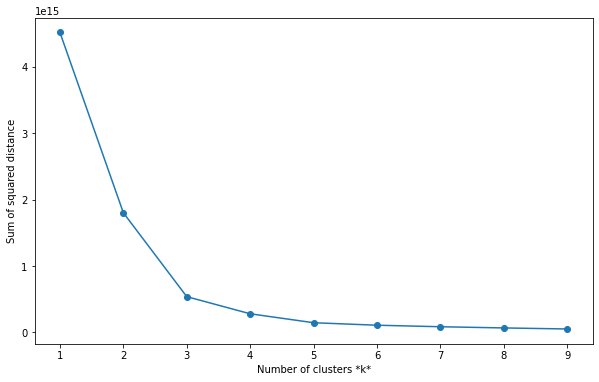

In [0]:
sse = []
list_k = list(range(1, 10))
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(df)
    sse.append(km.inertia_)
# Plot sse against k
plt.figure(figsize=(10, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [0]:
# elbow method suggests k = 3

###### K-Means

In [0]:
kmeans = KMeans(n_clusters=8, random_state=0)
kmeans.fit(df)
df['cluster_kmeans'] = kmeans.labels_
print(df['cluster_kmeans'].value_counts())

0 246
6 125
3 107
4 76
7 49
1 28
2 16
5 14
Name: cluster_kmeans, dtype: int64

In [0]:
#most important features for other faults (ref. 'explain')
cols = [
'Y_Minimum',
'Y_Maximum',
'Steel_Plate_Thickness',
'Edges_Y_Index',
'Pixels_Areas',
'Minimum_of_Luminosity',
'Length_of_Conveyer',
'Edges_Index',
'Maximum_of_Luminosity',
'Empty_Index',
'Edges_X_Index']

###### Steel Plate Dimensions

Comment: 
 * Majority of 'Other Faults' contists of Steel Type A400 (ref.nb.: 'explain')
   * Most important feature for distinguishing between common v. other faults
 * Other faults can be clustered in three groups based on Y Dimensions
   * Distance bewteen c1 & c2 is kind of overlapping
   * Distance between (c1,c2) & c3 is clear

In [0]:
print(df['TypeOfSteel_A400'].value_counts()) #majority is steel A400 (the MIF for 'Other_Faults') 

1 402
0 259
Name: TypeOfSteel_A400, dtype: int64

Out[110]:

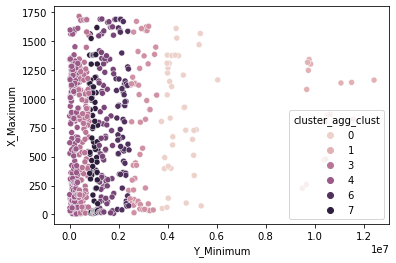

<AxesSubplot:xlabel='Y_Minimum', ylabel='X_Maximum'>

In [0]:
sns.scatterplot(y = 'X_Maximum', x = 'Y_Minimum', hue='cluster_agg_clust', data = df)

/databricks/python/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning:

50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/databricks/python/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning:

50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/databricks/python/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning:

50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/databricks/python/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning:

50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

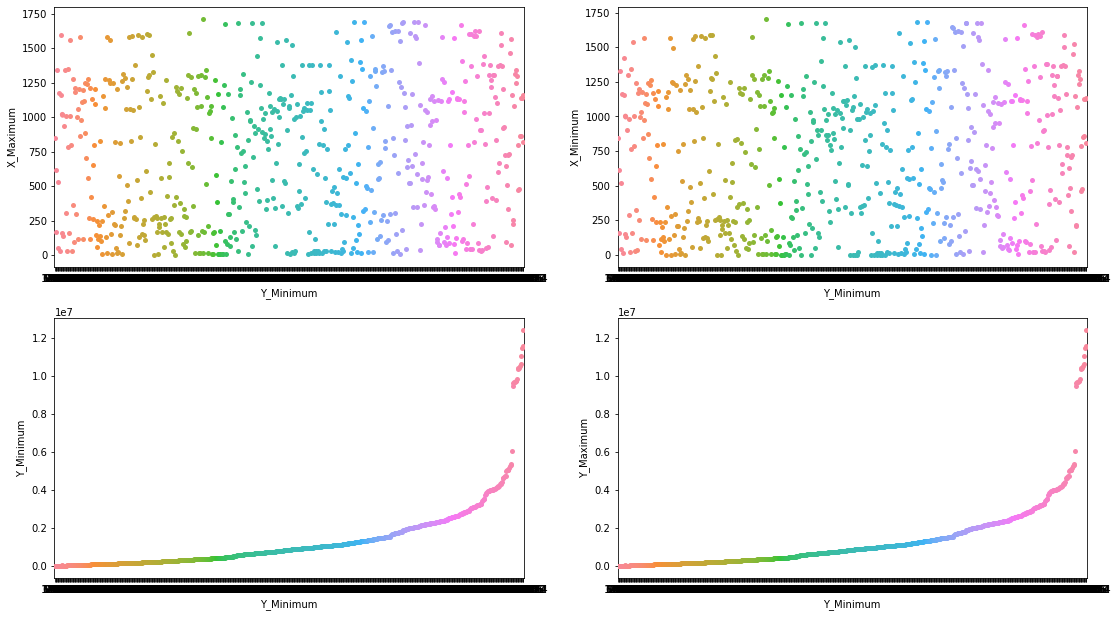

In [0]:
names = ['X_Maximum', 'X_Minimum', 'Y_Minimum', 'Y_Maximum']
fig, axes = plt.subplots(2,2)
fig.set_size_inches(18.5, 10.5, forward=True)
# Iterating through axes and names
for name, ax in zip(names, axes.flatten()):
    sns.scatterplot(y = name, x = 'Y_Minimum', hue='cluster_kmeans', data = df, ax=ax)

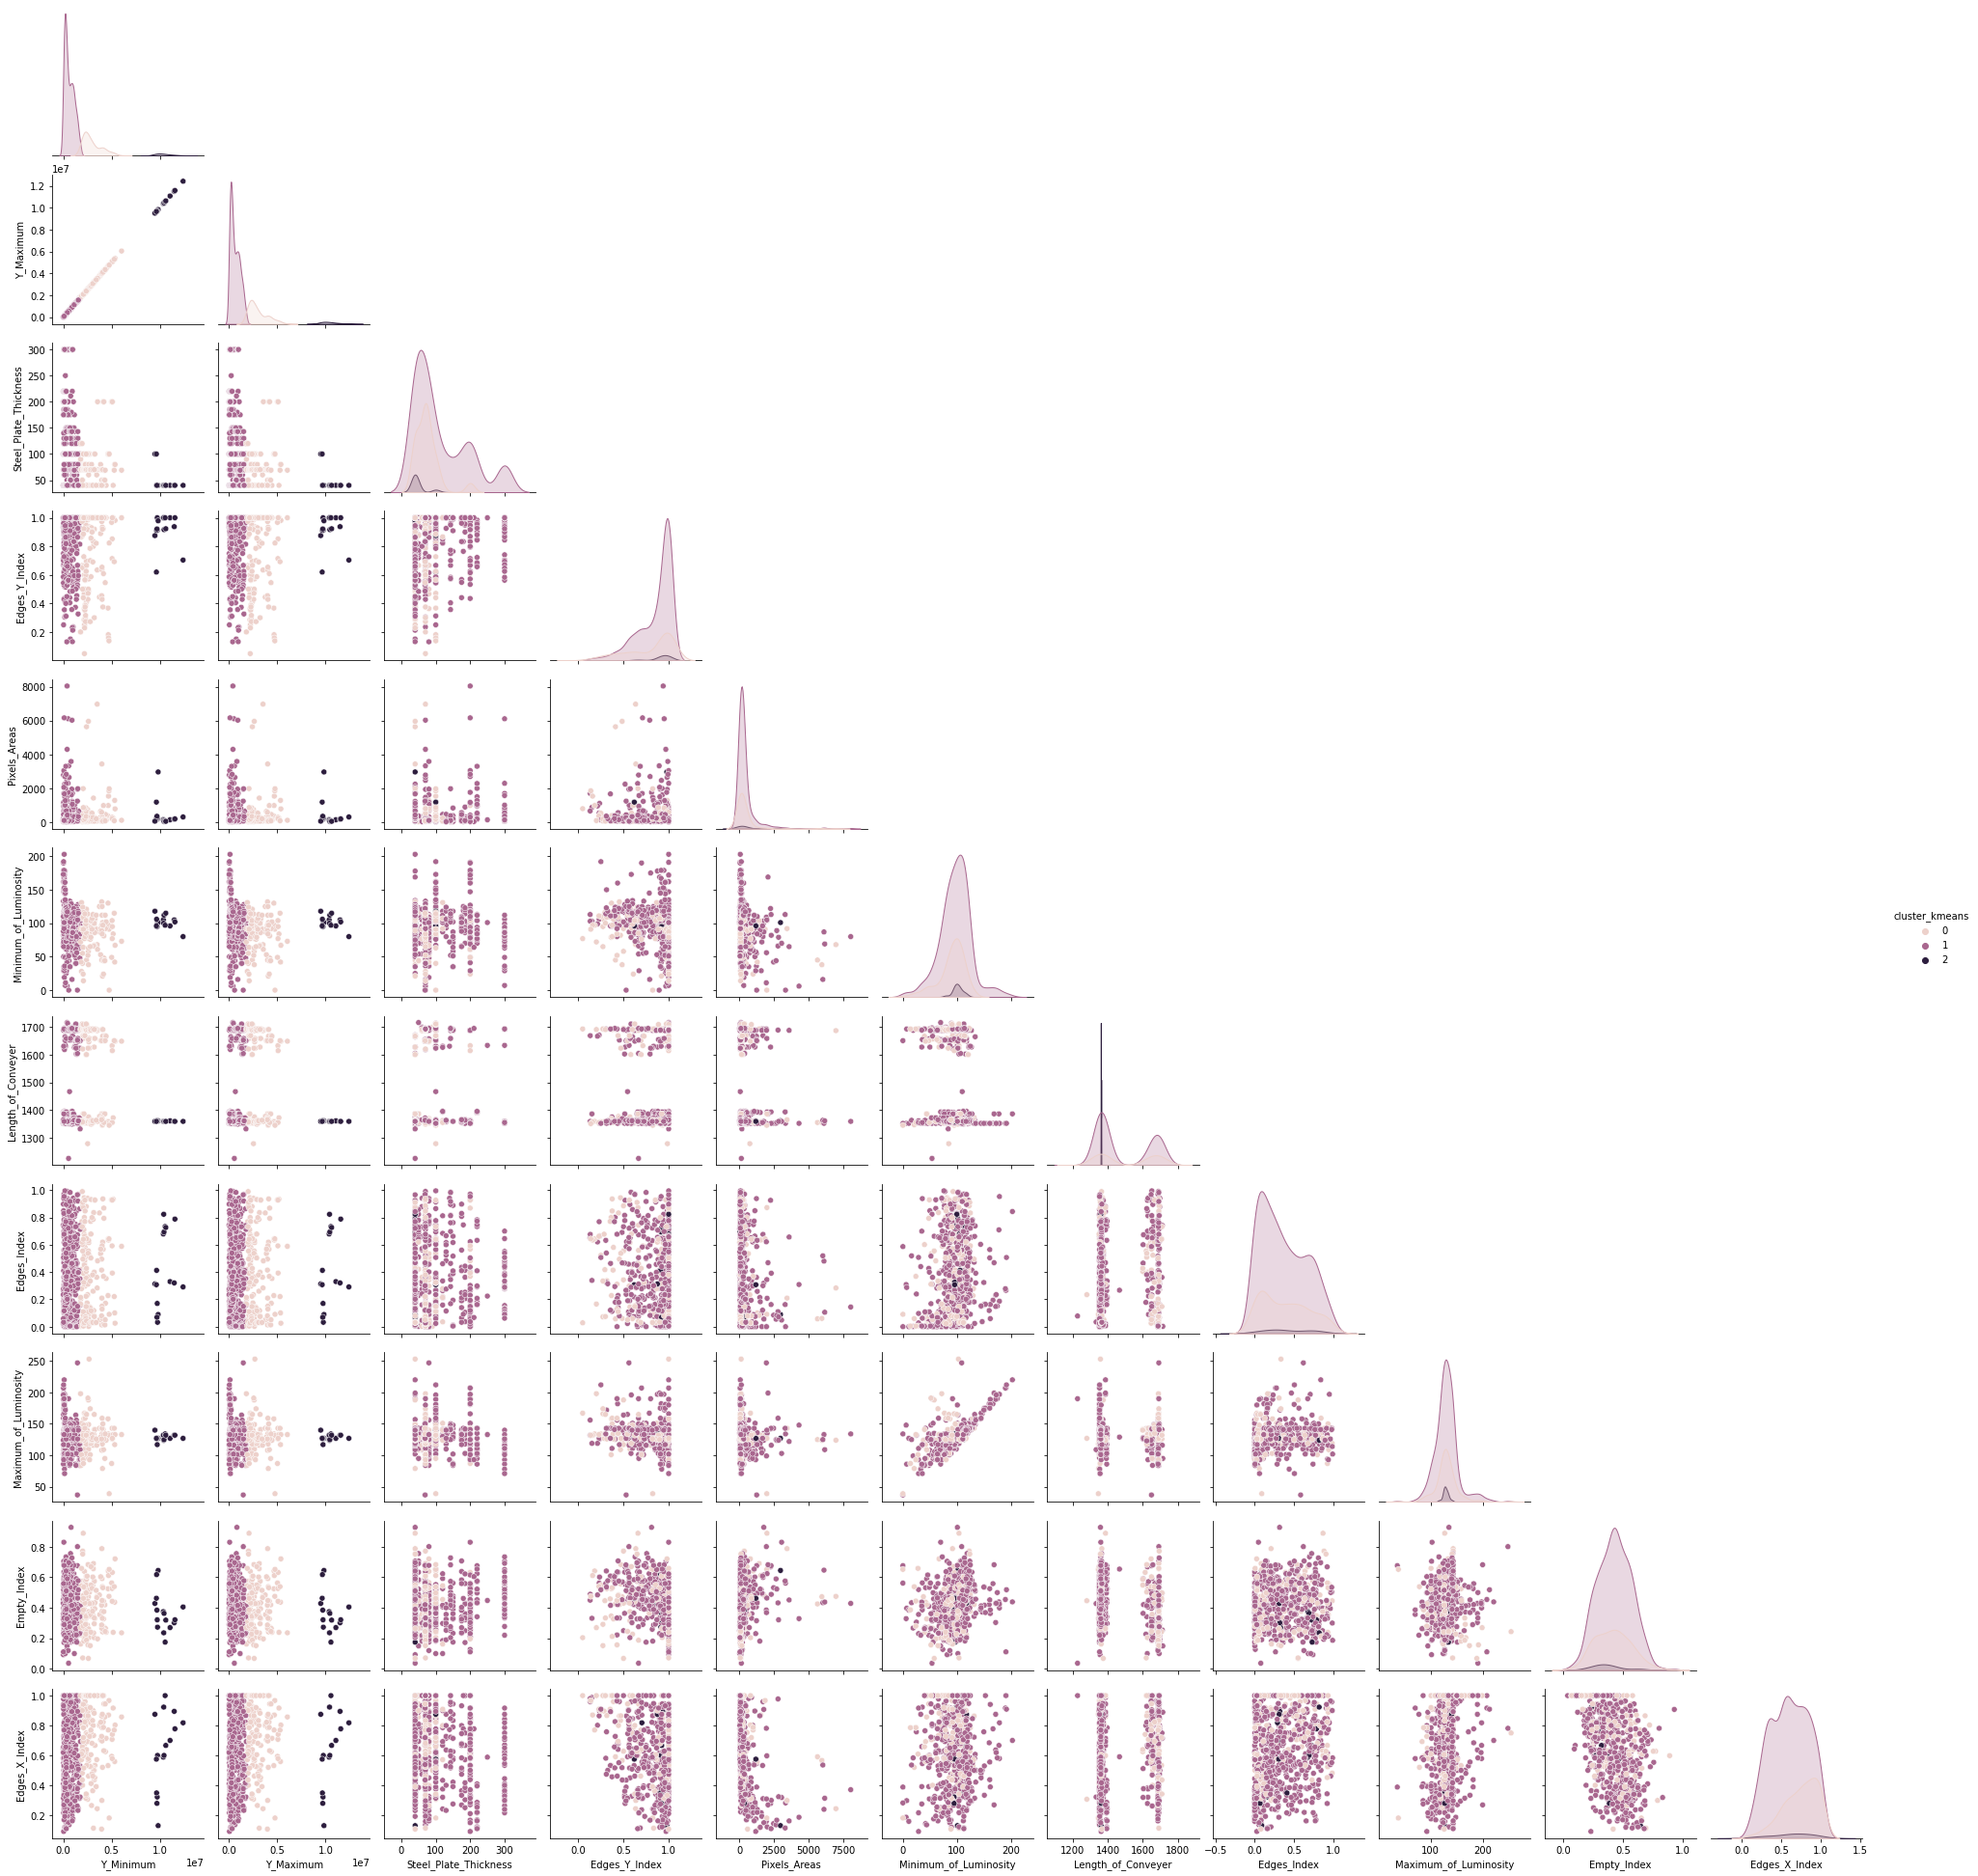

In [0]:
sns.pairplot(data=df, hue="cluster_kmeans", vars=cols, corner=True);

##### Agglomerative Clustering

In [0]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)#df = df.drop('cluster_kmeans', axis = 1)
    
    
    
agg_clust = AgglomerativeClustering(n_clusters=8, linkage = 'ward').fit(df) #same result as k-means
df['cluster_agg_clust'] = agg_clust.labels_
df['cluster_agg_clust'].value_counts()

Out[115]: 4 201
3 116
7 95
5 79
6 61
2 54
0 39
1 16
Name: cluster_agg_clust, dtype: int64

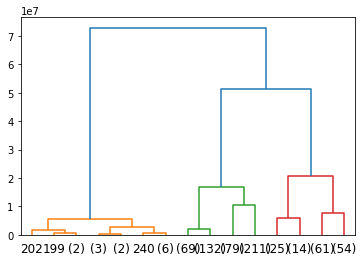

In [0]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(df)
plot_dendrogram(model, truncate_mode="level", p=3)

In [0]:
display(agg_clust)

--------------------------------------------------------------------------- 
 Exception Traceback (most recent call last)
 <command-349352039010677> in <module> 
 ----> 1 display ( agg_clust ) 

 /databricks/python_shell/scripts/PythonShellImpl.py in display (self, input, *args, **kwargs) 
 1046 self . displayHTML ( input . _repr_html_ ( ) ) 
 1047 else : 
 -> 1048 raise Exception ( genericErrorMsg ) 
 1049 
 1050 def displayHTML ( self , html ) : 

 Exception : Cannot call display(<class 'sklearn.cluster._agglomerative.AgglomerativeClustering'>)
 Call help(display) for more info.

/databricks/python/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning:

25.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/databricks/python/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning:

55.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/databricks/python/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning:

88.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/databricks/python/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning:

93.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/databricks/python/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning:

74.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/databricks/python/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning:

78.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/databricks/python/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning:

86.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

Out[109]:

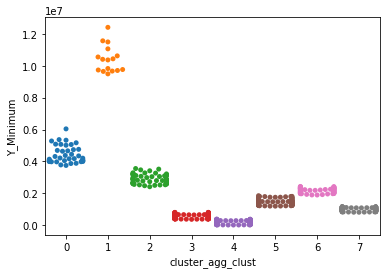

<AxesSubplot:xlabel='cluster_agg_clust', ylabel='Y_Minimum'>

In [0]:
sns.swarmplot(y = 'Y_Minimum', x = 'cluster_agg_clust', data = df)

##### Feature Agglomeration

In [0]:
f_agg_clust = FeatureAgglomeration(n_clusters=3).fit(df) 
df['cluster_f_agg_clust'] = agg_clust.labels_
df['cluster_f_agg_clust'].value_counts()

Out[17]: 0 606
2 39
1 16
Name: cluster_f_agg_clust, dtype: int64

/databricks/python/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 66.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
 warnings.warn(msg, UserWarning)
Out[18]:

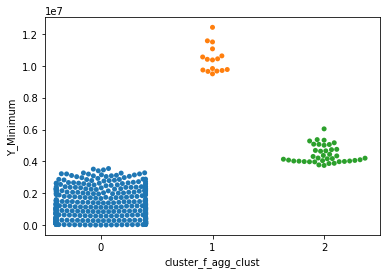

<AxesSubplot:xlabel='cluster_f_agg_clust', ylabel='Y_Minimum'>

In [0]:
sns.swarmplot(y = 'Y_Minimum', x = 'cluster_f_agg_clust', data = df)

##### Correlation Analysis of Clusters

In [0]:
df_corr = df.drop(['cluster_kmeans', 'cluster_agg_clust', 'cluster_f_agg_clust'], axis = 1)
df_dum = pd.get_dummies(df.cluster_agg_clust)
df_corr = pd.concat([df_in, df_dum], axis=1) 

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-2205308288263973> in <module> 
 1 df_corr = df . drop ( [ 'cluster_kmeans' , 'cluster_agg_clust' , 'cluster_f_agg_clust' ] , axis = 1 ) 
 2 df_dum = pd . get_dummies ( df . cluster_agg_clust ) 
 ----> 3 df_corr = pd . concat ( [ df_in , df_dum ] , axis = 1 ) 

 NameError : name 'df_in' is not defined

#### Radar Plot All Labels

In [0]:
df_mc = spark.sql('SELECT * from default.steel_faults_oversampled_multiclass')
df_mc = df_mc.toPandas()

In [0]:
cols = [
'Y_Minimum',
'Y_Maximum',
'Steel_Plate_Thickness',
'Edges_Y_Index',
'Pixels_Areas',
'Minimum_of_Luminosity',
'Length_of_Conveyer',
'Edges_Index',
'Maximum_of_Luminosity',
'Empty_Index',
'Edges_X_Index',
'labels']

mif = [
'TypeOfSteel_A400',
'Square_Index',
'Y_Minimum',
'Minimum_of_Luminosity',
'Steel_Plate_Thickness',
'Y_Perimeter',
'Edges_X_Index',
'Length_of_Conveyer',
'Orientation_Index',
'LogOfAreas',
'X_Minimum',
'labels']

In [0]:
df_mc = df_mc[mif] #keep most important features only
X = df_mc.drop(['labels'], axis = 1)
y = df_mc.labels.to_numpy() #series to array -> scale_to_df

In [0]:
def scale_to_df(X,y,df):
    X = MinMaxScaler().fit_transform(X) 
    data = np.hstack((X, y.reshape(-1,1)))
    return pd.DataFrame(data, columns = df.columns)

df_mc = scale_to_df(X,y, df_mc)
target_names = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
target_names_1 = ['Other_Faults', 'Bumps']
target_names_2 = ['Bumps', 'Other_Faults']

In [0]:
def plot_radar(df, target_names):
    avg_df = df.groupby("labels").mean()
    fig = go.Figure()

    for i in range(len(target_names)):
        fig.add_trace(
                    go.Scatterpolar(
                                    r=avg_df.loc[i].values,
                                    theta=avg_df.columns,
                                    fill='toself',
                                    name=target_names[i],
                                    showlegend=True,
                                    )
                    )

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                            visible=True,
                            range=[0, 1]
                        )
                ),
        #title="Radar Plot Most Important Features"
        title="Radar Plot For Feature Importance"
    )

    fig.show()

In [0]:
plot_radar(df_mc, target_names)

In [0]:
plot_radar(df_mc, target_names_2)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-221209454811735> in <module> 
 ----> 1 plot_radar ( df_mc , target_names_2 ) 

 NameError : name 'target_names_2' is not defined

In [0]:
# Overlapping Labels
# 'Pastry' & 'Stains'
# 'Z_Scratch' & 'Dirtiness'

sep = [
'TypeOfSteel_A400',
'Square_Index',
'Y_Minimum',
'Minimum_of_Luminosity',
'Steel_Plate_Thickness',
'Y_Perimeter',
'Edges_X_Index',
'Length_of_Conveyer',
'Orientation_Index',
'LogOfAreas',
'X_Minimum]

File "<command-3211499312531064>" , line 16 
 'X_Minimum] 
 ^
 SyntaxError : EOL while scanning string literal

In [0]:
def plot_radar(df, target_names):    
    avg_df = df.groupby("labels").mean()
    fig = go.Figure()

    for i in range(len(target_names)):
        fig.add_trace(
                    go.Scatterpolar(
                                    r=avg_df.loc[i].values,
                                    theta=avg_df.columns,
                                    fill='toself',
                                    name=target_names[i],
                                    showlegend=True,
                                    )
                    )
        
    layout=go.Layout(updatemenus=list([dict(buttons= list_updatemenus)]))

    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                            visible=True,
                            range=[0, 1]
                        )
                ),
        #title="Radar Plot Most Important Features"
        title="Radar Plot For Feature Importance - Uncommon Faults"
    )

    fig.show()




--------------------------------------------------------------------------- 
 ModuleNotFoundError Traceback (most recent call last)
 <command-221209454811737> in <module> 
 1 from plotly . offline import init_notebook_mode , iplot
 2 import plotly . graph_objects as go
 ----> 3 import cufflinks as cf
 4 init_notebook_mode ( connected = True ) 
 5 

 /databricks/python_shell/dbruntime/PythonPackageImportsInstrumentation/__init__.py in import_patch (name, globals, locals, fromlist, level) 
 156 # Import the desired module. If you’re seeing this while debugging a failed import, 
 157 # look at preceding stack frames for relevant error information. 
 --> 158 original_result = python_builtin_import ( name , globals , locals , fromlist , level ) 
 159 
 160 is_root_import = thread_local . _nest_level == 1 

 ModuleNotFoundError : No module named 'cufflinks'

In [0]:
plot_radar(df_mc, target_names)

--------------------------------------------------------------------------- 
 NameError Traceback (most recent call last)
 <command-221209454811738> in <module> 
 ----> 1 plot_radar ( df_mc , target_names ) 

 <command-221209454811737> in plot_radar (df, target_names) 
 15 r = avg_df . loc [ i ] . values , 
 16 theta = avg_df . columns , 
 ---> 17 fill = 'toself' , 
 18 name = target_names [ i ] , 
 19 showlegend = True , 

 NameError : name 'list_updatemenus' is not defined

In [0]:
cols = df.columns

In [0]:
cols

Out[86]: Index(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
 'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
 'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
 'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_Plate_Thickness',
 'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
 'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
 'SigmoidOfAreas', 'cluster_kmeans', 'cluster_agg_clust',
 'cluster_f_agg_clust'],
 dtype='object')